In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
grid_df = pd.read_csv('./data/grid_data.csv')
grid_df = grid_df.fillna(0)
grid_df.head()

,day,solar (MW),wind (MW),load (MW),solar_forcast (MW),wind_forecast (MW),load_forecast (MW),price (EUR/MWh),emission factor (kg CO2/MWh)
0,0,0.0,5393.0,11257.0,0.0,6053.0,10783.0,0.10,73.013522
1,0,0.0,5415.0,11279.0,0.0,6037.0,10713.0,0.10,73.013522
2,0,0.0,5405.0,11291.0,0.0,6023.0,10626.0,0.10,73.013522
3,0,0.0,5411.0,11266.0,0.0,6008.0,10527.0,0.10,73.013522
4,0,0.0,5441.0,11312.0,0.0,5993.0,10457.0,0.01,73.224798


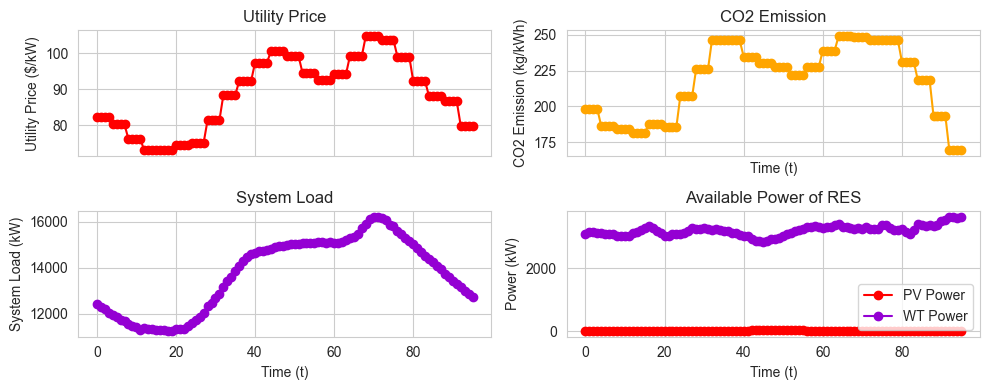

In [3]:
DAY_NUM = 5

grid_df[grid_df['day']==DAY_NUM]["emission factor (kg CO2/MWh)"].to_numpy()

pv_data = grid_df[grid_df['day']==DAY_NUM]["solar (MW)"].to_numpy()
wt_data = grid_df[grid_df['day']==DAY_NUM]["wind (MW)"].to_numpy()
price_data = grid_df[grid_df['day']==DAY_NUM]["price (EUR/MWh)"].to_numpy()
load_data = grid_df[grid_df['day']==DAY_NUM]["load (MW)"].to_numpy()
co2_data = grid_df[grid_df['day']==DAY_NUM]["emission factor (kg CO2/MWh)"].to_numpy()

# Create the index array (1 to 24) for the horizontal axis
t = np.arange(0, len(pv_data))

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 4), sharex=True)
axs = axs.flatten()

# Plot Price_utility
axs[0].plot(t, price_data, marker='o', linestyle='-', color='r')
axs[0].set_ylabel('Utility Price ($/kW)')
axs[0].set_title('Utility Price')
axs[0].grid(True)

# Plot CO2_emission
axs[1].plot(t, co2_data, marker='o', linestyle='-', color='orange')
axs[1].set_xlabel('Time (t)')
axs[1].set_ylabel('CO2 Emission (kg/kWh)')
axs[1].set_title('CO2 Emission')
axs[1].grid(True)

# Plot Power_load
axs[2].plot(t, load_data, marker='o', linestyle='-', color='darkviolet')
axs[2].set_xlabel('Time (t)')
axs[2].set_ylabel('System Load (kW)')
axs[2].set_title('System Load')
axs[2].grid(True)

# Plot PV/Wind
axs[3].plot(t, pv_data, marker='o', linestyle='-', color='r', label='PV Power')
axs[3].plot(t, wt_data, marker='o', linestyle='-', color='darkviolet', label='WT Power')
axs[3].set_xlabel('Time (t)')
axs[3].set_ylabel('Power (kW)')
axs[3].set_title('Available Power of RES')
axs[3].grid(True)
axs[3].legend(loc='lower right')

# Show the plot
plt.tight_layout()
plt.show()

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

class GridTimeSeriesDataset:
    def __init__(self, dataframe, scale=False):

        self.dataframe = dataframe
        self.days = np.sort(self.dataframe['day'].unique())  # Unique sorted days
        self.train, self.test = train_test_split(self.days, test_size=0.1, random_state=42)

        self.scale = scale
        if self.scale: self.load_samples()

        # Compute min and max values for normalization
        self.min = dataframe.min()
        self.max = dataframe.max()

    def __len__(self):
        return len(self.days)

    def __getitem__(self, index):
        if index >= len(self.days):
            raise IndexError("Index out of range")

        day = self.days[index]
        day_data = self.dataframe[self.dataframe['day'] == day].copy()
        
        if self.scale:
            day_data['solar (MW)'] = self.min_max_scale(day_data['solar (MW)'], ts_type='solar')
            day_data['wind (MW)'] = self.min_max_scale(day_data['wind (MW)'], ts_type='wind')
            day_data['load (MW)'] = self.min_max_scale(day_data['load (MW)'], ts_type='load')
            day_data['price (EUR/MWh)'] = self.min_max_scale(day_data['price (EUR/MWh)'], ts_type='price')
            day_data['emission factor (kg CO2/MWh)'] = self.min_max_scale(day_data['emission factor (kg CO2/MWh)'], ts_type='co2')
            # day_data['solar (MW)'] = self.scale_feature(day_data['solar (MW)'], ts_type='solar')
            # day_data['solar (MW)'] = self.remove_bias(day_data['solar (MW)'])
            # day_data['wind (MW)'] =  self.scale_feature(day_data['wind (MW)'], ts_type='wind')
            # day_data['load (MW)'] =  self.scale_feature(day_data['load (MW)'], ts_type='load')


        return {
            'time': np.arange(len(day_data)),  # Time indices
            'solar': day_data['solar (MW)'].to_numpy(dtype=np.float32),
            'wind': day_data['wind (MW)'].to_numpy(dtype=np.float32),
            'load': day_data['load (MW)'].to_numpy(dtype=np.float32),
            'solar_forecast': day_data['solar_forcast (MW)'].to_numpy(dtype=np.float32),
            'wind_forecast': day_data['wind_forecast (MW)'].to_numpy(dtype=np.float32),
            'load_forecast': day_data['load_forecast (MW)'].to_numpy(dtype=np.float32),
            'price': day_data['price (EUR/MWh)'].to_numpy(dtype=np.float32),
            'emission_factor': day_data['emission factor (kg CO2/MWh)'].to_numpy(dtype=np.float32),
        }
    
    def load_samples(self):
        # Load sample time series (to scale to the sample data)
        sample_solar = np.repeat(np.load('./data/sample/pv.npy'), 4)
        sample_wind = np.repeat(np.load('./data/sample/wt.npy'), 4)
        sample_load = np.repeat(np.load('./data/sample/load.npy'), 4)
        sample_price = np.repeat(np.load('./data/sample/price.npy'), 4)
        sample_co2 = np.repeat(np.load('./data/sample/co2.npy'), 4)/1000

        # Compute the mean and std of the sample time series
        self.mean_solar = np.mean(sample_solar)
        self.std_solar = np.std(sample_solar)
        self.min_solar = np.min(sample_solar)
        self.max_solar = np.max(sample_solar)

        self.mean_wind = np.mean(sample_wind)
        self.std_wind = np.std(sample_wind)
        self.min_wind = np.min(sample_wind)
        self.max_wind = np.max(sample_wind)

        self.mean_load = np.mean(sample_load)
        self.std_load = np.std(sample_load)
        self.min_load = np.min(sample_load)
        self.max_load = np.max(sample_load)

        self.mean_price = np.mean(sample_price)
        self.std_price = np.std(sample_price)
        self.min_price = np.min(sample_price)
        self.max_price = np.max(sample_price)

        self.mean_co2 = np.mean(sample_co2)
        self.std_co2 = np.std(sample_co2)
        self.min_co2 = np.min(sample_co2)
        self.max_co2 = np.max(sample_co2)

    # Apply Z-score standardization and rescale to sample's mean and std
    def scale_feature(self, data, ts_type):
        if ts_type == 'solar': mean_sample, std_sample = self.mean_solar, self.std_solar
        elif ts_type == 'wind': mean_sample, std_sample = self.mean_wind, self.std_wind
        elif ts_type == 'load': mean_sample, std_sample = self.mean_load, self.std_load

        feature_mean = np.mean(data)
        feature_std = np.std(data)
        return (data - feature_mean) / feature_std * std_sample + mean_sample

    def remove_bias(self, data):
        return data - np.min(data)
    
    def min_max_scale(self, data, ts_type):
        if ts_type == 'solar': min_sample, max_sample = self.min_solar, self.max_solar
        elif ts_type == 'wind': min_sample, max_sample = self.min_wind, self.max_wind
        elif ts_type == 'load': min_sample, max_sample = self.min_load, self.max_load
        elif ts_type == 'price': min_sample, max_sample = self.min_price, self.max_price
        elif ts_type == 'co2': min_sample, max_sample = self.min_co2, self.max_co2
        min_data = np.min(data)
        max_data = np.max(data)
        return (data - min_data) / (max_data - min_data) * (max_sample - min_sample) + min_sample


# Example Usage:
dataset = GridTimeSeriesDataset(grid_df, scale=True)
sample = dataset[42]
# print(sample)

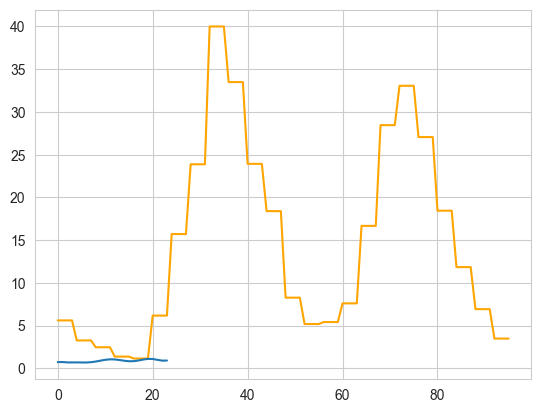

In [5]:
plt.plot(sample['price'], label='Solar', color='orange')
plt.plot(np.load('./data/sample/co2.npy')/1000)

In [6]:
dataset.max_co2

1.1096211007539336

### Temporal Gym Env

Text(0, 0.5, 'State of Charge (%)')

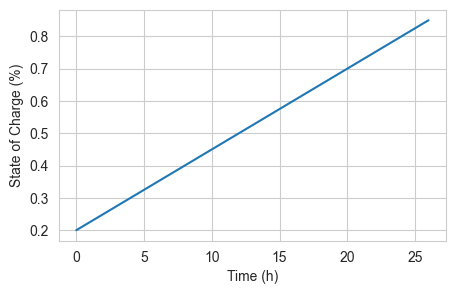

In [7]:
class storage:
    def __init__(self, SOC, dt):
        # Parameters
        self.eta_charge = 1
        self.eta_discharge = 1
        self.Capacity = 40 # kWh
        # Constraints
        self.Pbatt_max = 4 # kW
        self.SOC_min = 0.2
        self.SOC_max = 0.85
        # Variables
        self.SOC = np.clip(SOC, self.SOC_min, self.SOC_max)
        self.dt = dt

    def update(self, Pbatt):
        self.SOC += (self.eta_charge/self.Capacity)*np.maximum(0, Pbatt)*self.dt +\
                    (1/self.eta_discharge/self.Capacity)*min(0, Pbatt)*self.dt
        return self.SOC


test_battery = storage(SOC=0.2, dt=1)
SOC_PLOT = [test_battery.SOC]

while test_battery.SOC<test_battery.SOC_max:
    Pbatt = 1
    test_battery.update(Pbatt)

    SOC_PLOT.append(test_battery.SOC)

plt.figure(figsize=(5,3))
plt.plot(SOC_PLOT)
plt.grid(True)
plt.xlabel('Time (h)')
plt.ylabel('State of Charge (%)')

In [8]:
#  Define the dictionary
DG_coeffs = {
    "MT": {
        "Pmin": 6,  # kW
        "Pmax": 30, # kW
        "b" : 4.37, # €/kWh
        "c": 85.06, # €/h
        "ef": 724.6/1000,# kg/kWh
        "Type": "Microturbine"
    },
    "FC": {
        "Pmin": 3,   # kW
        "Pmax": 30,  # kW
        "b": 2.84,   # €/kWh
        "c": 255.18, # €/h
        "ef": 489.4/1000, # kg/kWh
        "Type": "FC"
    },
    "WT": {
        "Pmin": 0,  # kW
        "Pmax": 15, # kW
        "b": 10.63, # €/kWh
        "c": 0,     # €/h
        "ef": 0,    # kg/MWh
        "Type": "Wind Turbine"
    },
    "PV1": {
        "Pmin": 0,  # kW
        "Pmax": 3,  # kW
        "b": 54.84, # €/kWh
        "c": 0,     # €/h
        "ef": 0,    # kg/MWh
        "Type": "Photovoltaic 1"
    },
    "PV2": {
        "Pmin": 0 , # kW
        "Pmax": 10, # kW
        "b": 54.84, # €/kWh
        "c": 0,     # €/h
        "ef": 0,    # kg/MWh
        "Type": "Photovoltaic 2"
    }
}

# Print the dictionary
pprint(DG_coeffs)


{'FC': {'Pmax': 30,
        'Pmin': 3,
        'Type': 'FC',
        'b': 2.84,
        'c': 255.18,
        'ef': 0.4894},
 'MT': {'Pmax': 30,
        'Pmin': 6,
        'Type': 'Microturbine',
        'b': 4.37,
        'c': 85.06,
        'ef': 0.7246},
 'PV1': {'Pmax': 3,
         'Pmin': 0,
         'Type': 'Photovoltaic 1',
         'b': 54.84,
         'c': 0,
         'ef': 0},
 'PV2': {'Pmax': 10,
         'Pmin': 0,
         'Type': 'Photovoltaic 2',
         'b': 54.84,
         'c': 0,
         'ef': 0},
 'WT': {'Pmax': 15,
        'Pmin': 0,
        'Type': 'Wind Turbine',
        'b': 10.63,
        'c': 0,
        'ef': 0}}


In [9]:
# Function to add Gaussian noise with varying intensity and proportional to power
def add_uncertainty(time_series, start_time, base_noise_std):
    time_steps = np.linspace(0, len(time_series), len(time_series))
    noisy_series = time_series.copy()
    start_index = np.searchsorted(time_steps, start_time)+1
    total_horizon = len(time_series) - start_index

    # Define the Gaussian uncertainty function
    for i in range(start_index, len(time_series)):
        time_distance = (i - start_index) / total_horizon  # Normalize distance to [0, 1]
        # Gaussian function for uncertainty, centered at the midpoint of the horizon
        uncertainty_scale = np.exp(-0.5 * ((time_distance - 1) ** 2) / (0.7 ** 2))  # Narrow Gaussian
        noise_scale = base_noise_std * uncertainty_scale  # Scale noise by the Gaussian function
        noise = np.random.normal(0, noise_scale) * noisy_series[i]
        noisy_series[i] += noise

    noisy_series[start_index:] = np.clip(noisy_series[start_index:], 0, None)  # Ensure no negative power
    return noisy_series

In [10]:
import gymnasium as gym
import numpy as np

class MicroGridTemporalEnv(gym.Env):
    def __init__(self, grid_df, DG_coeffs):
        super(MicroGridTemporalEnv, self).__init__()
        
        self.day = 0  # Start at the first day
        self.t = 0
        self.dt = 0.25  # Time step (hours)
        self.MAX_STEP = 24 * (1 / self.dt)  # Number of time steps in a day

        self.timeseries = GridTimeSeriesDataset(grid_df, scale=True)
        self.DG_coeffs = DG_coeffs
        self.battery = storage(SOC=0.5, dt=self.dt)

        self.PGmax = 200
        self.PBmax = self.battery.Pbatt_max
        self.bigM = 10

        self.Bi = [v["b"] for v in DG_coeffs.values()]
        self.Ci = [v["c"] for v in DG_coeffs.values()]
        self.EFi = [v["ef"] for v in DG_coeffs.values()]

        # Get min/max values from the dataset for normalization
        self.data_min = grid_df.min()
        self.data_max = grid_df.max()

        # Define action space: [-1,1] mapped to actual power ranges
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(3,), dtype=np.float32)
        # Define observation space: Normalize relevant state variables to [-1,1]
        self.observation_space = gym.spaces.Box(low=-1, high=1, shape=(7,), dtype=np.float32)

        self.memory = {'power': [], 'storage': []}


    def normalize(self, value, min_val, max_val):
        return 2 * (value - min_val) / (max_val - min_val) - 1


    def denormalize(self, value, min_val, max_val):
        return (value + 1) / 2 * (max_val - min_val) + min_val


    def step(self, action):
        # Get the time-series data for the current day
        day_data = self.timeseries[self.day]

        Pbatt = self.denormalize(action[0], -self.PBmax, self.PBmax)
        Pgi = [
            self.denormalize(action[1], list(self.DG_coeffs.values())[0]['Pmin'], list(self.DG_coeffs.values())[0]['Pmax']),
            self.denormalize(action[2], list(self.DG_coeffs.values())[1]['Pmin'], list(self.DG_coeffs.values())[1]['Pmax'])
        ]
        
        # Get time-series values
        DEMAND = day_data['load'][self.t]
        BG = day_data['price'][self.t]
        EFG = day_data['emission_factor'][self.t]
        PV = day_data['solar'][self.t]
        WIND = day_data['wind'][self.t]

        self.battery.update(Pbatt)

        Pgi_all = np.hstack([Pgi, [WIND, PV, PV]])
        PG = -(Pgi_all.sum() - Pbatt - DEMAND)
        
        Power_Cost = np.sum(self.Bi[:2] * Pgi_all[:2] + self.Ci[:2]) + (BG * PG)
        Env_Cost = np.sum(self.EFi[:2] * Pgi_all[:2]) + (EFG * PG)

        PG_constraint = np.maximum(0, PG - self.PGmax) + np.maximum(0, -self.PGmax - PG)

        Battery_constraint = np.clip(self.battery.SOC - self.battery.SOC_max, 0, np.inf) + \
                             np.clip(self.battery.SOC_min - self.battery.SOC, 0, np.inf)
        
        reward = -(Power_Cost + 1e-2 * Env_Cost) / 1e3 - self.bigM * (PG_constraint + 20 * Battery_constraint) + 2
        
        self.t += 1  # Move to the next time step
        done = self.t >= self.MAX_STEP  # End episode if all time steps are completed
        
        # Get next state
        next_DEMAND = day_data['load'][self.t] if not done else 0
        next_BG = day_data['price'][self.t] if not done else 0
        next_EFG = day_data['emission_factor'][self.t] if not done else 0
        next_PV = day_data['solar'][self.t] if not done else 0
        next_WIND = day_data['wind'][self.t] if not done else 0

        next_state = np.array([
            self.normalize(self.t, 0, self.MAX_STEP),
            self.normalize(next_DEMAND, self.timeseries.min_load, self.timeseries.max_load),
            self.normalize(next_WIND, self.timeseries.min_wind, self.timeseries.max_wind),
            self.normalize(next_PV, self.timeseries.min_solar, self.timeseries.max_solar),
            self.normalize(next_BG, self.timeseries.min_price, self.timeseries.max_price),
            self.normalize(next_EFG, self.timeseries.min_co2, self.timeseries.max_co2),
            self.normalize(self.battery.SOC, 0, 1)
        ])

        # Prepare the full observation (return the whole time-series data at each step)
        time_series = np.stack([
            self.normalize(add_uncertainty(day_data['load'],  self.t, base_noise_std=0.2), self.timeseries.min_load, self.timeseries.max_load),   # Demand
            self.normalize(add_uncertainty(day_data['wind'],  self.t, base_noise_std=0.2), self.timeseries.min_wind, self.timeseries.max_wind),   # Wind generation
            self.normalize(add_uncertainty(day_data['solar'], self.t, base_noise_std=0.2), self.timeseries.min_solar, self.timeseries.max_solar)  # PV generation
        ], axis=0).T

        next_observation =[time_series.astype(np.float32), next_state.astype(np.float32)]

        self.memory['power'].append(np.hstack([PG, Pbatt, Pgi, [WIND, PV, PV]]))
        self.memory['storage'].append(self.battery.SOC)
        
        info = {'NEXT DEMAND': DEMAND, 'Power_Cost': Power_Cost, 'Env_Cost': Env_Cost}
        return next_observation, reward, done, False, info

    def reset(self, test=False, day=None):
        self.t = 0
        self.battery = storage(SOC=0.5, dt=self.dt)
        if day is not None:
            self.day = day
        else:
            self.day = np.random.choice(self.timeseries.test) if test else np.random.choice(self.timeseries.train)

        day_data = self.timeseries[self.day]

        DEMAND = day_data['load'][self.t]
        BG = day_data['price'][self.t]
        EFG = day_data['emission_factor'][self.t]
        PV = day_data['solar'][self.t]
        WIND = day_data['wind'][self.t]

        state = np.array([
            self.normalize(self.t, 0, self.MAX_STEP),
            self.normalize(DEMAND, self.timeseries.min_load, self.timeseries.max_load),
            self.normalize(WIND, self.timeseries.min_wind, self.timeseries.max_wind),
            self.normalize(PV, self.timeseries.min_solar, self.timeseries.max_solar),
            self.normalize(BG, self.timeseries.min_price, self.timeseries.max_price),
            self.normalize(EFG, self.timeseries.min_co2, self.timeseries.max_co2),
            self.normalize(self.battery.SOC, 0, 1)
        ])


        # Prepare the full observation (return the whole time-series data at each step)
        time_series = np.stack([
            self.normalize(add_uncertainty(day_data['load'],  self.t, base_noise_std=0.2), self.timeseries.min_load, self.timeseries.max_load),   # Demand
            self.normalize(add_uncertainty(day_data['wind'],  self.t, base_noise_std=0.2), self.timeseries.min_wind, self.timeseries.max_wind),   # Wind generation
            self.normalize(add_uncertainty(day_data['solar'], self.t, base_noise_std=0.2), self.timeseries.min_solar, self.timeseries.max_solar)  # PV generation
        ], axis=0).T

        observation =[time_series.astype(np.float32), state.astype(np.float32)]

        self.memory['power'] = []
        self.memory['storage'] = []
        
        info = {'DEMAND': DEMAND, 'Power_Cost': 0, 'Env_Cost': 0}
        return observation, info

    def render(self):
        return 0

# Example Usage
env = MicroGridTemporalEnv(grid_df, DG_coeffs)
env.action_space, env.observation_space, env.reset(), env.step(np.ones(4,))

(Box(-1.0, 1.0, (3,), float32),
 Box(-1.0, 1.0, (7,), float32),
 ([array([[-0.40713513,  1.        , -1.        ],
          [-0.52362657,  0.71046984, -1.        ],
          [-0.46633655,  0.82313085, -1.        ],
          [-0.65507436,  0.48681927, -1.        ],
          [-0.5579058 ,  0.6961156 , -1.        ],
          [-0.7240962 ,  0.48484254, -1.        ],
          [-0.7767794 ,  0.42913473, -1.        ],
          [-0.8517823 ,  0.43283963, -1.        ],
          [-0.7874032 ,  0.43124437, -1.        ],
          [-0.7879351 ,  0.4138167 , -1.        ],
          [-0.9637771 ,  0.27300513, -1.        ],
          [-0.9073253 ,  0.3929087 , -1.        ],
          [-0.9718054 ,  0.27799165, -1.        ],
          [-1.0374918 ,  0.04924512, -1.        ],
          [-1.044178  ,  0.00675309, -1.        ],
          [-0.9554002 ,  0.03199911, -1.        ],
          [-0.86278975, -0.03818315, -1.        ],
          [-0.9810827 ,  0.25055015, -1.        ],
          [-0.9382

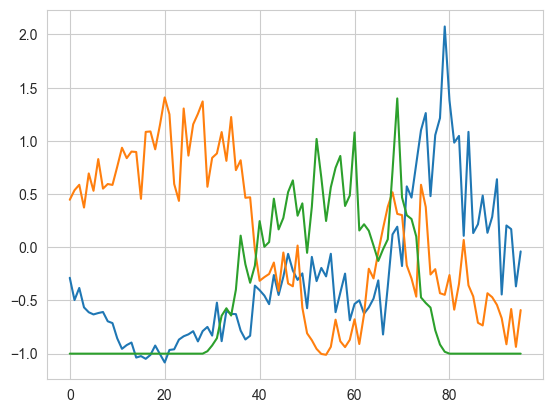

In [11]:
o,a = env.reset()
plt.plot(o[0])

## RL code

### Attention Layer

In [12]:
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, hidden_dim, max_len=96):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, hidden_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        freq_term = torch.arange(hidden_dim//2)+1
        
        pe[:, 0::2] = torch.sin((2/max_len)*torch.pi*position * freq_term)
        pe[:, 1::2] = torch.cos((2/max_len)*torch.pi*position * freq_term)[:, :pe[:, 1::2].shape[1]]

        self.pe = pe.unsqueeze(0)  # Shape: (1, max_len, input_dim)

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :].to(x.device)  # Ensure correct shape & device

class AttentionBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, reduced_dim, max_len=96):
        super(AttentionBlock, self).__init__()
        self.positional_encoding = PositionalEncoding(hidden_dim, max_len)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=1, batch_first=True)
        self.in_projection = nn.Linear(input_dim, hidden_dim)
        self.out_projection = nn.Linear(hidden_dim, 1)
        self.tanh = nn.Tanh()
        self.reduced_fc = nn.Linear(max_len, reduced_dim)

    def forward(self, x):
        x = self.in_projection(x)
        x = self.positional_encoding(x)  # Add positional encoding
        attn_x, _ = self.attention(x, x, x)
        attn_output = self.out_projection(attn_x)
        embeddings = self.tanh(attn_output)

        embeddings = embeddings.reshape(-1, 96)  # Take the output of the last LSTM step
        features = self.reduced_fc(embeddings)
        return features

# Example usage
batch_size = 5
seq_len = 96
input_dim = 3
hidden_dim = 8
num_heads = 1

# Instantiate attention block
attention_block = AttentionBlock(input_dim=input_dim, hidden_dim=hidden_dim, reduced_dim=8)

# Create a random input tensor
seq_input = torch.randn(batch_size, seq_len, input_dim)  # (batch, 24, 3)

# Forward pass
output = attention_block(seq_input)

# Print shapes
print("Input Shape:", seq_input.shape)  # (batch_size, 24, 3)
print("Output Shape:", output.shape)  # (batch_size, 24, 1)

Input Shape: torch.Size([5, 96, 3])
Output Shape: torch.Size([5, 8])


#### Models

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.distributions import Normal

device = "cuda" if torch.cuda.is_available() else "cpu"

sequence_length = 24 
attention_input_dim = 3   
attention_hidden_dim = 8
temporal_vector_dim = 8

# Gaussian Policy Network architecture
class GaussianPolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims, temporal_dim):
        super().__init__()

        # Fully connected branch for single-vector state input
        layers = []
        input_dim = temporal_dim + state_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim
        self.fc_branch = nn.Sequential(*layers)

        # Final layers for mean and log standard deviation
        self.fc_mean = nn.Linear(input_dim, action_dim)
        self.fc_log_std = nn.Linear(input_dim, action_dim)

    def forward(self, temporal_vector, state_vector):
        # Concatenate state and temporal outputs
        augmented_vector = torch.cat([temporal_vector, state_vector], dim=-1)

        # Process single-vector state input
        fc_out = self.fc_branch(augmented_vector)

        # Compute mean and std of actions
        action_mean = self.fc_mean(fc_out)
        action_log_std = torch.clamp(self.fc_log_std(fc_out), min=-5, max=2)  # Adjusted range
        action_std = torch.exp(action_log_std)
        return action_mean, action_std

    def select_action(self, temporal_vector, state_vector, deterministic=False):
        mean, std = self(temporal_vector, state_vector)
        if deterministic: 
            action = torch.tanh(mean)  # Directly apply tanh for deterministic mode
            log_prob = torch.zeros_like(mean).sum(dim=-1, keepdim=True)
        else:
            normal_dist = Normal(mean, std)
            action_pre_tanh = normal_dist.rsample()  # Sample before applying tanh
            log_prob = normal_dist.log_prob(action_pre_tanh).sum(dim=-1, keepdim=True)
            
            # Apply tanh transformation correctly
            action = torch.tanh(action_pre_tanh)
            # Log probability correction for tanh squashing
            log_prob -= torch.log(1 - action.pow(2) + 1e-6).sum(dim=-1, keepdim=True)
        return action, log_prob


# Q-Network architecture
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims, temporal_dim):
        super().__init__()

        # Fully connected branch for single-vector state and action input
        layers = []
        input_dim = temporal_dim + state_dim + action_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim
        self.fc_branch = nn.Sequential(*layers)

        # Final output layer for Q-value
        self.fc_out = nn.Linear(input_dim, 1)

    def forward(self, temporal_vector, state_vector, action):
        # Concatenate state vector and action
        state_action = torch.cat([temporal_vector, state_vector, action], dim=-1)

        # Process single-vector state and action input
        fc_out = self.fc_branch(state_action)
        q_value = self.fc_out(fc_out)
        return q_value

#### Agent

In [14]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from utils.asset import map_to_range, np_to_torch, torch_to_np
from utils.buffer import ReplayBuffer
from utils.plot import plot_return
from utils.logger import TensorboardWriter
import copy
from itertools import chain

device = "cuda" if torch.cuda.is_available() else "cpu"

class AttentionTRLAgent:
    def __init__(self, state_size, action_size, action_range, hidden_dim=[128], 
                 alpha=0.1, gamma=0.99, lr=3e-4, tau=0.005, buffer_size=1e5, batch_size=256):
        self.state_size = state_size
        self.action_size = action_size
        self.action_range = action_range
        self.gamma = gamma
        self.lr = lr
        self.tau = tau
        self.batch_size = batch_size
        self.memory = ReplayBuffer(int(buffer_size))

        # Trainable entropy temperature
        self.target_entropy = -action_size  # A heuristic for continuous action spaces
        self.log_alpha = torch.tensor(np.log(alpha), requires_grad=True, device=device)
        self.alpha_optimizer = optim.Adam([self.log_alpha], lr=self.lr)

        # Attention Temporal Embedding Module
        self.actor_embed = AttentionBlock(input_dim=attention_input_dim, hidden_dim=attention_hidden_dim, reduced_dim=temporal_vector_dim).to(device)
        self.critic_embed = AttentionBlock(input_dim=attention_input_dim, hidden_dim=attention_hidden_dim, reduced_dim=temporal_vector_dim).to(device)

        # Actor (policy)
        self.actor = GaussianPolicyNetwork(state_size, action_size, hidden_dim, temporal_vector_dim).to(device)

        # Critics
        self.QNet1 = QNetwork(state_size, action_size, hidden_dim, temporal_vector_dim).to(device)
        self.target_QNet1 = QNetwork(state_size, action_size, hidden_dim, temporal_vector_dim).to(device)
        self.target_QNet1.load_state_dict(self.QNet1.state_dict())

        self.QNet2 = QNetwork(state_size, action_size, hidden_dim, temporal_vector_dim).to(device)
        self.target_QNet2 = QNetwork(state_size, action_size, hidden_dim, temporal_vector_dim).to(device)
        self.target_QNet2.load_state_dict(self.QNet2.state_dict())

        # Optimizers
        self.actor_optimizer = optim.Adam(chain(self.actor.parameters(), self.actor_embed.parameters()), lr=self.lr, weight_decay=1e-4)
        self.QNet1_optimizer = optim.Adam(chain(self.QNet1.parameters(), self.critic_embed.parameters()), lr=self.lr, weight_decay=1e-4)
        self.QNet2_optimizer = optim.Adam(chain(self.QNet2.parameters(), self.critic_embed.parameters()), lr=self.lr, weight_decay=1e-4)
        
        # Logging
        self.writer = TensorboardWriter(log_dir="Logs/AttentionTRLAgent", comment="AttentionTRLAgent")
        self.iter = 0
        self.best_avg_reward = -np.inf

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        # Sample from replay buffer
        states_ts, states, actions, action_log_probs, rewards, next_states_ts, next_states, dones = self.memory.sample(self.batch_size)

        # Convert data to PyTorch tensors
        states_ts = torch.tensor(states_ts, dtype=torch.float32).to(device)
        states = torch.tensor(states, dtype=torch.float32).to(device)
        actions = torch.tensor(actions, dtype=torch.float32).to(device)
        action_log_probs = torch.tensor(action_log_probs, dtype=torch.float32).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        next_states_ts = torch.tensor(next_states_ts, dtype=torch.float32).to(device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
        dones = torch.tensor(dones, dtype=torch.float32).to(device)
        
        # Compute Q targets
        with torch.no_grad():
            # temporal features
            next_embeddings = self.actor_embed(next_states_ts)
            next_actions, next_action_log_probs = self.actor.select_action(next_embeddings, next_states)
            alpha = self.log_alpha.exp()  # Convert log_alpha to alpha
            next_embeddings = self.critic_embed(next_states_ts)
            q_values_next = torch.min(self.target_QNet1(next_embeddings, next_states, next_actions), 
                                      self.target_QNet2(next_embeddings, next_states, next_actions)) - alpha * next_action_log_probs
            q_targets = rewards + (self.gamma * q_values_next * (1 - dones))
            q_targets = q_targets.detach()

        # Update Q1
        embeddings = self.critic_embed(states_ts)
        q1_values = self.QNet1(embeddings, states, actions)
        Q1_loss = F.mse_loss(q1_values, q_targets)
        self.QNet1_optimizer.zero_grad()
        Q1_loss.backward()
        self.QNet1_optimizer.step()

        # Update Q2
        embeddings = self.critic_embed(states_ts)
        q2_values = self.QNet2(embeddings, states, actions)
        Q2_loss = F.mse_loss(q2_values, q_targets)
        self.QNet2_optimizer.zero_grad()
        Q2_loss.backward()
        self.QNet2_optimizer.step()

        # Compute actor loss
        embeddings = self.actor_embed(states_ts)
        actions, action_log_probs = self.actor.select_action(embeddings, states)
        with torch.no_grad(): embeddings = self.critic_embed(states_ts)
        actor_loss = -(torch.min(self.QNet1(embeddings, states, actions), self.QNet2(embeddings, states, actions)) - alpha * action_log_probs).mean()

        # Update actor network
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update alpha (train entropy)
        alpha_loss = -self.log_alpha * (action_log_probs + self.target_entropy).detach().mean()
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()

        # Log loss values
        if self.iter%1e3 == 0:
            self.writer.log_scalar("Loss/Actor", actor_loss, self.iter)
            self.writer.log_scalar("Loss/Q1", Q1_loss, self.iter)
            self.writer.log_scalar("Loss/Q2", Q2_loss, self.iter)
            self.writer.log_scalar("Loss/Alpha", alpha_loss, self.iter)
            self.writer.log_scalar("Param/Alpha", alpha, self.iter)
        self.iter += 1

        # Soft update of target networks
        for target_param, param in zip(self.target_QNet1.parameters(), self.QNet1.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for target_param, param in zip(self.target_QNet2.parameters(), self.QNet2.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


    def evaluate(self, env):
        one_episode_return = 0
        for d in env.timeseries.test:
            state, _ = env.reset(test=True, day=d)
            done = False
            score = 0
            while not done:
                # Use the policy to select an action (without exploration)
                state_t = [np_to_torch(state[0]).to(device), np_to_torch(state[1]).to(device)]
                embeddings = self.actor_embed(state_t[0])
                action_t, _ = self.actor.select_action(embeddings, state_t[1], deterministic=True)
                action = torch_to_np(action_t)
                mapped_action = map_to_range(action, self.action_range)
                next_state, reward, done, _, _ = env.step(mapped_action)
                state = next_state
                score += reward
            one_episode_return += score
        if one_episode_return/len(env.timeseries.test) > self.best_avg_reward:
            self.best_avg_reward = one_episode_return/len(env.timeseries.test)
            torch.save(self.actor.state_dict(), "Logs/AttentionTRLAgent_best_actor.pth")
            torch.save(self.actor_embed.state_dict(), "Logs/AttentionTRLAgent_best_embed.pth")
            print(f"New best model saved with average reward: {self.best_avg_reward}")

        return one_episode_return/len(env.timeseries.test)

    def train(self, env, episodes):
        returns = []
        for episode in range(episodes):
            one_episode_return = 0
            for d in env.timeseries.train:
                score = 0
                length = 0
                done = False
                state, _ = env.reset(day=d)
                while not done:
                    # convert to tensor
                    state_t = [np_to_torch(state[0]).to(device), np_to_torch(state[1]).to(device)]
                    embeddings = self.actor_embed(state_t[0])
                    # select action
                    action_t, action_log_prob_t = self.actor.select_action(embeddings, state_t[1])
                    # convert to numpy
                    action = torch_to_np(action_t)
                    action_log_prob = torch_to_np(action_log_prob_t)
                    # map action to range
                    mapped_action = map_to_range(action, self.action_range)
                    # take action
                    next_state, reward, done, _, info = env.step(mapped_action)
                    # store in memory
                    self.memory.push([state[0], state[1], action, action_log_prob, reward, next_state[0], next_state[1], done])
                    # train agent
                    self.learn()
                    state = next_state
                    score += reward
                    length += 1
                one_episode_return += score
            # log episode info
            self.writer.log_scalar("Episode/Return", one_episode_return/len(env.timeseries.train), episode)
            self.writer.log_scalar("Episode/Length", length, episode)
            # store episode return
            returns.append(one_episode_return/len(env.timeseries.train))
            # plot_return(returns, f'Soft Actor Critic (SAC) ({device})')
            # Evaluation
            if (episode + 1) % 1 == 0: 
                eval_return = self.evaluate(env)
                self.writer.log_scalar("Episode/Return_Eval", eval_return, episode)
        env.close()
        self.writer.close()
        return returns


#### Training

In [15]:
torch.manual_seed(0)

state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
action_max = env.action_space.high

env = MicroGridTemporalEnv(grid_df, DG_coeffs)
agent = AttentionTRLAgent(state_size, action_size, action_range=[env.action_space.low, env.action_space.high], hidden_dim=[256,256], buffer_size=1e5)
# result = agent.train(env, episodes=100000)

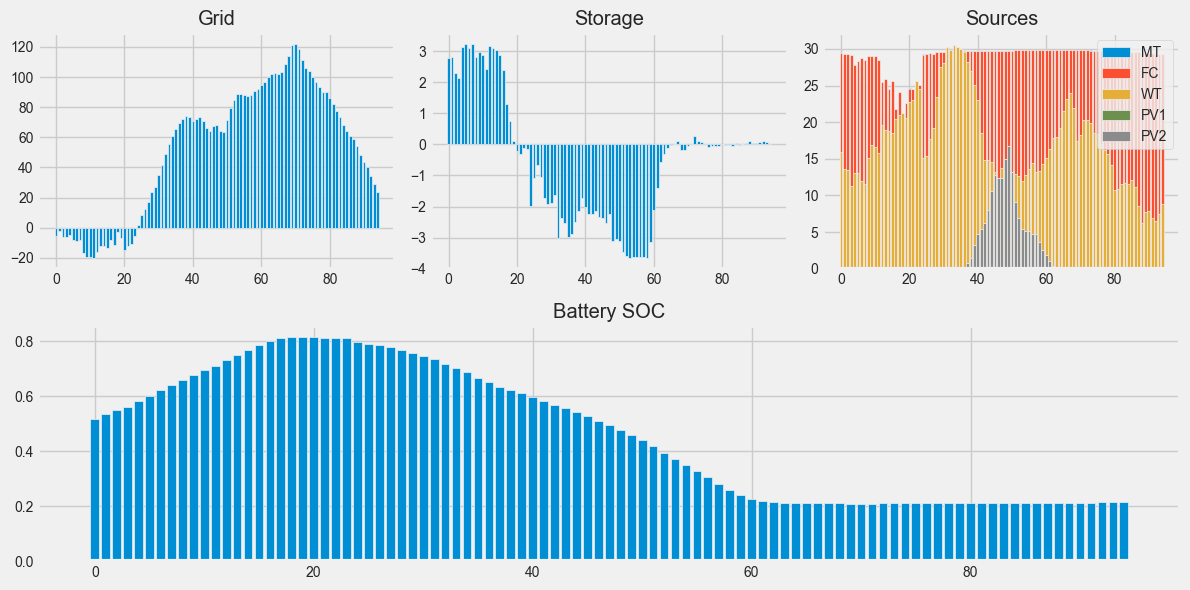

-3.6723521696596086


In [16]:
import torch
from utils.asset import map_to_range, np_to_torch, torch_to_np
device = "cuda" if torch.cuda.is_available() else "cpu"

agent.actor_embed.load_state_dict(torch.load("Logs/AttentionTRLAgent_best_embed.pth", weights_only=True))
agent.actor.load_state_dict(torch.load("Logs/AttentionTRLAgent_best_actor.pth", weights_only=True))

state,_ = env.reset(test=True, day=1)

grid_results = []
rewards = []
actions = []

done = False
while not done:
    grid_results = np.array(env.memory['power'])
    battery_results = np.array(env.memory['storage'])

    # convert to tensor
    state_t = [np_to_torch(state[0]).to(device), np_to_torch(state[1]).to(device)]
    embeddings = agent.actor_embed(state_t[0])
    # select action
    action_t, action_log_prob_t = agent.actor.select_action(embeddings, state_t[1], deterministic=True)
    # convert to numpy
    action = torch_to_np(action_t)
    action_log_prob = torch_to_np(action_log_prob_t)
    # map action to range
    mapped_action = map_to_range(action, agent.action_range)
    # take action

    next_state, reward, done, _, info = env.step(mapped_action)
    
    state = next_state
    rewards.append(reward)

plt.figure(figsize=(12,6))
plt.subplot(2,3,1)
plt.bar(range(len(grid_results[:,0])), grid_results[:,0])
plt.title('Grid')
plt.subplot(2,3,2)
plt.bar(range(len(grid_results[:,1])), grid_results[:,1])
plt.title('Storage')
plt.subplot(2,3,3)
for i in range(grid_results[:,2:].shape[1]):
    plt.bar(range(len(grid_results)), grid_results[:,2+i], label=list(env.DG_coeffs.keys())[i])
plt.legend()
plt.title('Sources')
plt.subplot(2,1,2)
plt.bar(range(len(battery_results)), battery_results)
plt.title('Battery SOC')
plt.tight_layout()
plt.show()

print(sum(rewards))

# Evaluation

In [19]:
from tqdm import tqdm
from time import time

train_costs = []
train_times = []

for NUM_DAY in tqdm(dataset.train):
    state,_ = env.reset(test=False, day=NUM_DAY)

    rewards = []
    actions = []

    done = False
    while not done:        
        # convert to tensor
        state_t = [np_to_torch(state[0]).to(device), np_to_torch(state[1]).to(device)]
        # select action
        time1 = time()
        embeddings = agent.actor_embed(state_t[0])
        # select action
        action_t, action_log_prob_t = agent.actor.select_action(embeddings, state_t[1], deterministic=True)
        train_times.append(time()-time1)
        # convert to numpy
        action = torch_to_np(action_t)
        action_log_prob = torch_to_np(action_log_prob_t)
        # map action to range
        mapped_action = map_to_range(action, agent.action_range)
        # take action
        
        next_state, reward, done, _, info = env.step(mapped_action)
        
        state = next_state
        rewards.append(reward)
    train_costs.append(np.sum(rewards))
np.mean(train_costs), (np.mean(train_costs)-96*2)*(-1000), np.max(train_times)*96, np.mean(train_times)*96

100%|██████████| 329/329 [02:02<00:00,  2.69it/s]


(45.038445848224484, 146961.55415177552, 0.7204055786132812, 0.085430327882158)

In [18]:
from tqdm import tqdm

test_costs = []

for NUM_DAY in tqdm(dataset.test):
    state,_ = env.reset(test=True, day=NUM_DAY)

    rewards = []
    actions = []

    done = False
    while not done:
        # convert to tensor
        state_t = [np_to_torch(state[0]).to(device), np_to_torch(state[1]).to(device)]
        embeddings = agent.actor_embed(state_t[0])
        # select action
        action_t, action_log_prob_t = agent.actor.select_action(embeddings, state_t[1], deterministic=True)
        # convert to numpy
        action = torch_to_np(action_t)
        action_log_prob = torch_to_np(action_log_prob_t)
        # map action to range
        mapped_action = map_to_range(action, agent.action_range)
        # take action

        next_state, reward, done, _, info = env.step(mapped_action)
        
        state = next_state
        rewards.append(reward)
    test_costs.append(np.sum(rewards))
np.mean(test_costs), (np.mean(test_costs)-96*2)*(-1000)

100%|██████████| 37/37 [00:10<00:00,  3.47it/s]


(42.264284664824935, 149735.71533517505)